# Evaluate performance of LSTM (Model 1) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 1 using data from Shasta reservoir. Recall that LSTM Model 1 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1(a/b/c)_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.

We also look at each of the variants of Model 1:
1. Model 1a: standardization, MSE Loss
2. Model 1b: normalization, MSE Loss
3. Model 2c: normalization, RMSLE Loss

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized Data

In [5]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_std, dataset_val_std = (TensorDataset(X_train_std, y_train_std), TensorDataset(X_val_std, y_val_std))
# shuffle = False to preserve time order
dataloader_train_std, dataloader_val_std = (DataLoader(dataset_train_std, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_std, batch_size=1, shuffle=False))

### Normalized Data

In [6]:
# Run data processing pipeline
pipeline_nm = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1, transform_type='normalize', fill_na_method='mean')
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_nm, ts_val_nm, ts_test_nm = pipeline_nm.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_nm, X_val_nm, X_test_nm = ts_train_nm[:, :, [0, 3]], ts_val_nm[:, :, [0, 3]], ts_test_nm[:, :, [0, 3]]
# select outflow as target feature
y_train_nm, y_val_nm, y_test_nm = ts_train_nm[:, :, [1]], ts_val_nm[:, :, [1]], ts_test_nm[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_nm, dataset_val_nm = (TensorDataset(X_train_nm, y_train_nm), TensorDataset(X_val_nm, y_val_nm))
# shuffle = False to preserve time order
dataloader_train_nm, dataloader_val_nm = (DataLoader(dataset_train_nm, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_nm, batch_size=1, shuffle=False))

## Analyze Model 1a
Model 1(a) uses standardized inflow and DOY as input, and trains on MSE loss.

In [7]:
from src.models.model_zoo import *
from src.models.train_model import *

### Analyze Optimal Hyperparameters for Model 1a
Previously, we conducted a grid search over a predefined parameter space: \
Number LSTM layers; 1, 2\
Hidden size (LSTM): 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\
Hidden size (FF): 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\
Dropout probability: 0.3, 0.5, 0.7

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [8]:
# load in results from grid search
grid_df_1a = pd.read_csv('report/results/hyperparameter_tuning/model1a_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_1a['param_id'] = np.repeat(np.arange(int(len(grid_df_1a) / num_random_seeds)), num_random_seeds)
grid_df_mean_1a = grid_df_1a.groupby('param_id').mean()
grid_df_mean_1a.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_1a.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_1a.to_csv('report/results/hyperparameter_tuning/model1a_avg_tuning.csv')
grid_df_mean_1a[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
306,1.0,30.0,15.0,0.3,74.2,0.363413
324,1.0,30.0,45.0,0.3,60.8,0.368881
138,1.0,15.0,35.0,0.3,107.2,0.372677
441,1.0,40.0,40.0,0.3,68.2,0.374502
555,1.0,50.0,30.0,0.3,64.0,0.375822
319,1.0,30.0,35.0,0.5,89.8,0.377301
307,1.0,30.0,15.0,0.5,95.2,0.378819
315,1.0,30.0,30.0,0.3,62.2,0.378953
564,1.0,50.0,45.0,0.3,63.4,0.379373


In [9]:
# instantiate optimal model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model1a = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1a.parameters(), lr=0.001)

# load saved model
model1a.load_state_dict(torch.load('src/models/saved_models/model1a.pt'))

# turn model into evaluation model
model1a.eval()

LSTMModel1(
  (lstm_cell): LSTMCell(2, 30)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

In [10]:
count_parameters(model1a)

4561

### Evaluate Model 1a in training

In [11]:
from src.models.predict_model import *
from sklearn.metrics import r2_score

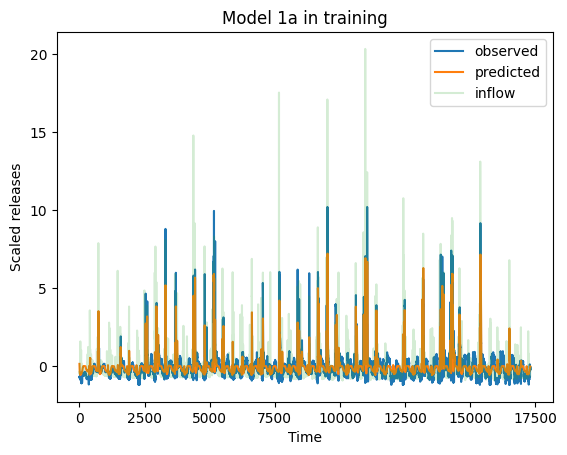

R2 of Model 1a in training: 0.7314395431004055


In [12]:
# flatten and remove pads
y_hat_train_1a, y_true_train_1a = flatten_rm_pad(y_hat=model1a(X_train_std)[0].detach(), y=y_train_std)

# check dimensions of datetime
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

assert len(y_true_train_1a) == original_train_len

plot_predicted_true(y_hat=y_hat_train_1a, y=y_true_train_1a)
plt.plot(((df.inflow[:(original_train_len)] - df.inflow[:(original_train_len)].mean()) / df.inflow[:(original_train_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title('Model 1a in training')
plt.show()

# R-squared
r2_train_1a = r2_score(y_true=y_true_train_1a, y_pred=y_hat_train_1a)
print(f'R2 of Model 1a in training: {r2_train_1a}')

### Evaluate Model 1a in testing

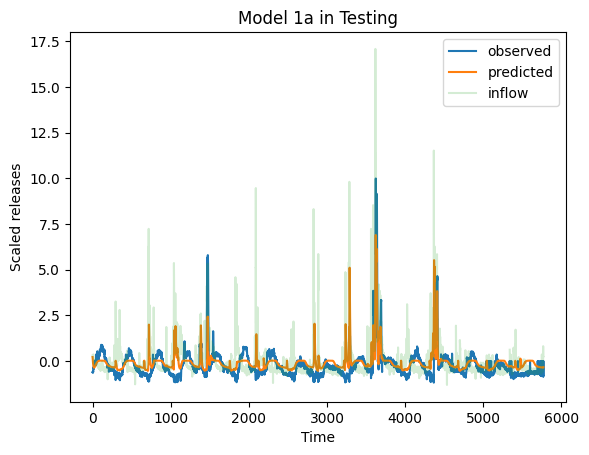

R2 of Model 1a in testing: 0.43345771749112927


In [13]:
# flatten and remove pads
y_hat_test_1a, y_true_test_1a = flatten_rm_pad(y_hat=model1a(X_test_std)[0].detach(), y=y_test_std)
# check dimensions
assert len(y_true_test_1a) == len(df.index) - (original_train_len + original_val_len)

plot_predicted_true(y_hat=y_hat_test_1a, y=y_true_test_1a)
plt.plot(((df.inflow[(original_train_len+original_val_len):] - df.inflow[(original_train_len+original_val_len):].mean()) / df.inflow[(original_train_len+original_val_len):].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title('Model 1a in Testing')
plt.show()

# R-squared
r2_test_1a = r2_score(y_true=y_true_test_1a, y_pred=y_hat_test_1a)
print(f'R2 of Model 1a in testing: {r2_test_1a}')

### Evaluate Model 1a in validation (for reference)

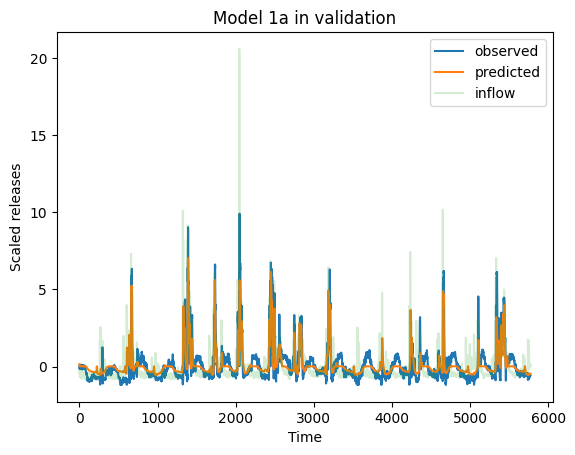

R2 of Model 1a in validation: 0.6861856266245214


In [14]:
y_hat_val_1a, y_true_val_1a = flatten_rm_pad(y_hat=model1a(X_val_std)[0].detach(), y=y_val_std)
assert len(y_true_val_1a) == original_val_len

plot_predicted_true(y_hat=y_hat_val_1a, y=y_true_val_1a)
plt.plot(((df.inflow[original_train_len:(original_train_len+original_val_len)] - df.inflow[original_train_len:(original_train_len+original_val_len)].mean()) / df.inflow[original_train_len:(original_train_len+original_val_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title(f'Model 1a in validation')
plt.show()

r2_val_1a = r2_score(y_true_val_1a, y_hat_val_1a)
print(f'R2 of Model 1a in validation: {r2_val_1a}')

In testing, the model exhibits far more "phantom" peaks compared to the validation and training sets. Performance in testing is also far lower than performance on the validation set. Could this be indicative of a policy change? Additionally note that the test set is much drier than the other datasets.

### Analyze cell memory states - FIXME: MOVE TO NEW NOTEBOOK

### Analyze correlations

In [15]:
from src.models.analyze_lstm_cell import *

# Get cell states, shape is (# chunks, timesteps, hidden size)
cell_train = model1a(X_train)[1].detach()
cell_val = model1a(X_val)[1].detach()
cell_test = model1a(X_test)[1].detach()

# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

correlation_data = {'training':cell_correlations(cell_states=cell_train, storage_states=storage_train),
                    'validation': cell_correlations(cell_states=cell_val, storage_states=storage_val),
                    'testing': cell_correlations(cell_states=cell_test, storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)

# Select cell with correlation > 0.30
df_corr.loc[df_corr['training'] > 0.30, :].sort_values(by='testing', ascending=False)

NameError: name 'X_train' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=18, ax=axes[1])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=7, ax=axes[2])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=29, ax=axes[3])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=8, ax=axes[4])

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Training cell states vs observed storages')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=18, ax=axes[1])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=7, ax=axes[2])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=29, ax=axes[3])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=8, ax=axes[4])

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Prediction cell states vs observed storages')
plt.tight_layout()
plt.show()

## Analyze Model 1(b)
Model 1(b) takes normalized inflow and DOY as input, and trains on MSE loss

### Analyze hyperparameters for Model 1b

In [16]:
# load in results from grid search
grid_df_1b = pd.read_csv('report/results/hyperparameter_tuning/model1b_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_1b['param_id'] = np.repeat(np.arange(int(len(grid_df_1b) / num_random_seeds)), num_random_seeds)
grid_df_mean_1b = grid_df_1b.groupby('param_id').mean()
grid_df_mean_1b.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_1b.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_1b.to_csv('report/results/hyperparameter_tuning/model1b_avg_tuning.csv')

grid_df_mean_1b[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
528,2.0,45.0,35.0,0.3,104.2,0.003237
327,1.0,30.0,50.0,0.3,117.8,0.003252
561,1.0,50.0,40.0,0.3,131.0,0.003252
324,1.0,30.0,45.0,0.3,122.8,0.003256
384,1.0,35.0,45.0,0.3,106.4,0.003279
591,2.0,50.0,40.0,0.3,93.8,0.003290
564,1.0,50.0,45.0,0.3,112.8,0.003316
444,1.0,40.0,45.0,0.3,97.0,0.003330
447,1.0,40.0,50.0,0.3,95.8,0.003332


### Evaluating train performance for Model 1b

In [17]:
# instantiate optimal model
input_size = 2
hidden_size1 = 45
hidden_size2 = 35
output_size = 1
dropout_prob = 0.3
num_layers = 2

torch.manual_seed(0)
model1b = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1b.parameters(), lr=0.001)

# load saved model
model1b.load_state_dict(torch.load('src/models/saved_models/model1b.pt'))
# turn model into evaluation model
model1b.eval()

LSTMModel1(
  (lstm_cell): LSTMCell(2, 45)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=45, out_features=35, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=35, out_features=1, bias=True)
)

In [18]:
count_parameters(model1b)

10466

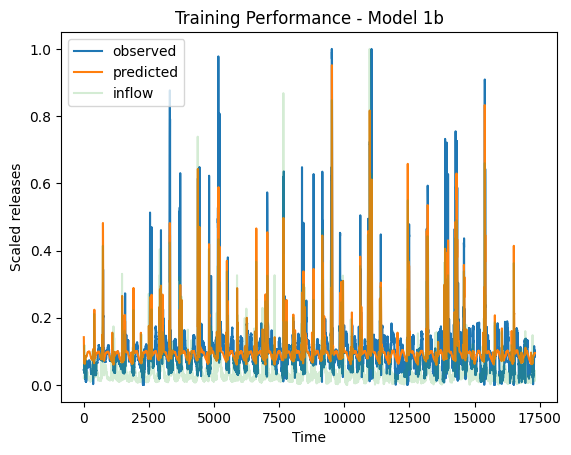

The R2 of Model 1b in training is: 0.6096324206441949


In [19]:
# flatten and remove pads
y_hat_train_1b, y_true_train_1b = flatten_rm_pad(y_hat=model1b(X_train_nm)[0].detach(), y=y_train_nm)

assert len(y_true_train_1b) == original_train_len

plot_predicted_true(y_hat=y_hat_train_1b, y=y_true_train_1b)
plt.plot(((df.inflow[:(original_train_len)] - df.inflow[:(original_train_len)].min()) / (df.inflow[:(original_train_len)].max() - df.inflow[:(original_train_len)].min())).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title('Training Performance - Model 1b')
plt.show()

r2_train_1b = r2_score(y_true=y_true_train_1b, y_pred=y_hat_train_1b)
print(f'The R2 of Model 1b in training is: {r2_train_1b}')

### Evaluate Test Performance for Model 1b

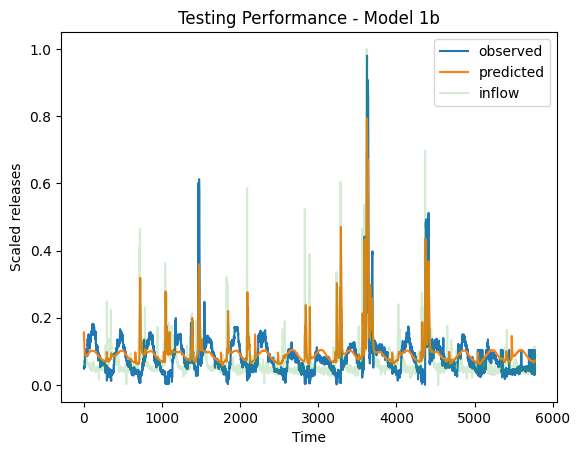

The R2 of Model 1b in testing is: 0.4559767834035613


In [20]:
# flatten and remove pads to plot
y_hat_test_1b, y_true_test_1b = flatten_rm_pad(y_hat=model1b(X_test_nm)[0].detach(), y=y_test_nm)
assert len(y_true_test_1b) == original_test_len

plot_predicted_true(y_hat=y_hat_test_1b, y=y_true_test_1b)
plt.plot(((df.inflow[(original_train_len+original_val_len):] - df.inflow[(original_train_len+original_val_len):].min()) / (df.inflow[(original_train_len+original_val_len):].max() - df.inflow[(original_train_len+original_val_len):].min())).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title('Testing Performance - Model 1b')
plt.show()

r2_test_1b = r2_score(y_true=y_true_test_1b, y_pred=y_hat_test_1b)
print(f'The R2 of Model 1b in testing is: {r2_test_1b}')

## Analyze Model 1(c)
Model 1(c) takes normalized inflow and DOY as input, and trains on RMSLE loss

### Analyze Hyperparameters for Model 1c

In [21]:
# load in results from grid search
grid_df_1c = pd.read_csv('report/results/hyperparameter_tuning/model1c_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_1c['param_id'] = np.repeat(np.arange(int(len(grid_df_1c) / num_random_seeds)), num_random_seeds)
grid_df_mean_1c = grid_df_1c.groupby('param_id').mean()
grid_df_mean_1c.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_1c.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_1c.to_csv('report/results/hyperparameter_tuning/model1c_avg_tuning.csv')

grid_df_mean_1c[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
282,2.0,25.0,25.0,0.3,137.0,0.042399
591,2.0,50.0,40.0,0.3,95.4,0.042668
387,1.0,35.0,50.0,0.3,114.6,0.042759
462,2.0,40.0,25.0,0.3,124.8,0.042930
528,2.0,45.0,35.0,0.3,119.4,0.042959
564,1.0,50.0,45.0,0.3,99.6,0.043339
597,2.0,50.0,50.0,0.3,107.8,0.043500
372,1.0,35.0,25.0,0.3,122.8,0.043516
441,1.0,40.0,40.0,0.3,121.2,0.043565


### Evaluate train performance for Model 1c

In [22]:
# instantiate optimal model
input_size = 2
hidden_size1 = 25
hidden_size2 = 25
output_size = 1
dropout_prob = 0.3
num_layers = 2

torch.manual_seed(0)
model1c = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1c.parameters(), lr=0.001)

# load saved model
model1c.load_state_dict(torch.load('src/models/saved_models/model1c.pt'))
# turn model into evaluation model
model1c.eval()

LSTMModel1(
  (lstm_cell): LSTMCell(2, 25)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=25, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=25, out_features=1, bias=True)
)

In [23]:
count_parameters(model1c)

3576

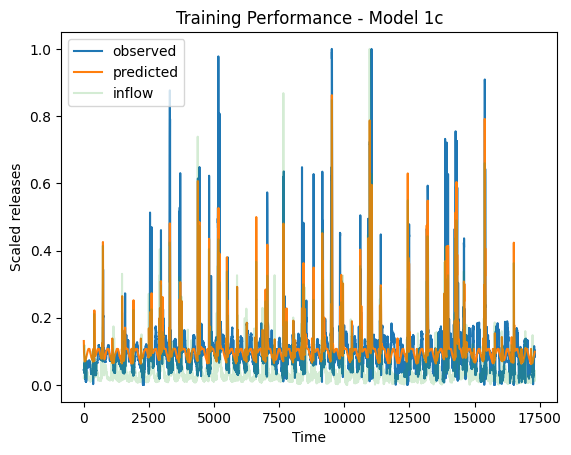

The R2 of Model 1c in training is: 0.618378738022816


In [28]:
# flatten and remove pads
y_hat_train_1c, y_true_train_1c = flatten_rm_pad(y_hat=model1c(X_train_nm)[0].detach(), y=y_train_nm)

assert len(y_true_train_1c) == original_train_len

plot_predicted_true(y_hat=y_hat_train_1c, y=y_true_train_1c)
plt.plot(((df.inflow[:(original_train_len)] - df.inflow[:(original_train_len)].min()) / (df.inflow[:(original_train_len)].max() - df.inflow[:(original_train_len)].min())).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title('Training Performance - Model 1c')
plt.show()

r2_train_1c = r2_score(y_true=y_true_train_1c, y_pred=y_hat_train_1c)
print(f'The R2 of Model 1c in training is: {r2_train_1c}')

### Evaluate in testing for Model 1c

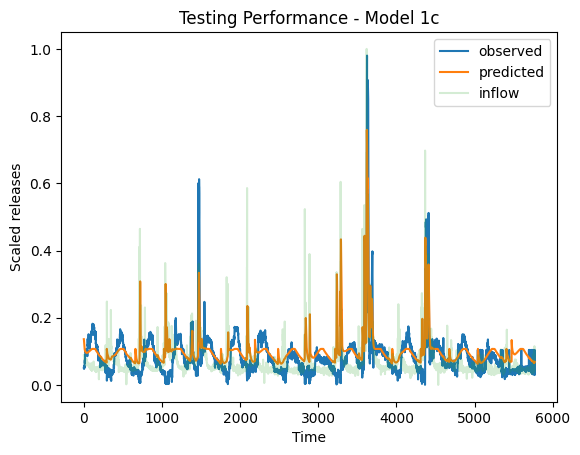

The R2 of Model 1c in testing is: 0.45642012508982843


In [30]:
# flatten and remove pads to plot
y_hat_test_1c, y_true_test_1c = flatten_rm_pad(y_hat=model1c(X_test_nm)[0].detach(), y=y_test_nm)
assert len(y_true_test_1c) == original_test_len

plot_predicted_true(y_hat=y_hat_test_1c, y=y_true_test_1c)
plt.plot(((df.inflow[(original_train_len+original_val_len):] - df.inflow[(original_train_len+original_val_len):].min()) / (df.inflow[(original_train_len+original_val_len):].max() - df.inflow[(original_train_len+original_val_len):].min())).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.title('Testing Performance - Model 1c')
plt.show()

r2_test_1c = r2_score(y_true=y_true_test_1c, y_pred=y_hat_test_1c)
print(f'The R2 of Model 1c in testing is: {r2_test_1c}')

## Review Performance

In [31]:
performance = {'training r2': [r2_train_1a, r2_train_1b, r2_train_1c], 
               'testing r2': [r2_test_1a, r2_test_1b, r2_test_1c]}
perf_df = pd.DataFrame(performance, index=['Model 1a', 'Model 1b', 'Model 1c'])
perf_df

,training r2,testing r2
Model 1a,0.731440,0.433458
Model 1b,0.609632,0.455977
Model 1c,0.618379,0.456420
